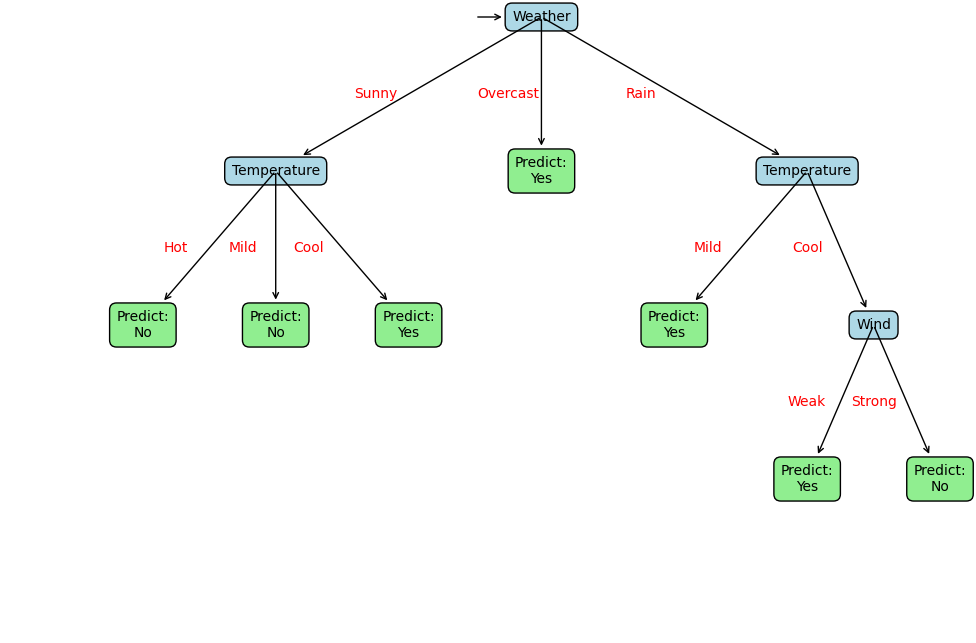

In [ ]:
import pandas as pd
import math
import matplotlib.pyplot as plt


def entropy(data, target_col):
    counts = data[target_col].value_counts()
    total = len(data)
    ent = 0
    for count in counts:
        p = count / total
        ent -= p * math.log2(p)
    return ent

def info_gain(data, feature, target_col):
    total_entropy = entropy(data, target_col)
    values = data[feature].unique()
    weighted_entropy = 0
    for val in values:
        subset = data[data[feature] == val]
        weighted_entropy += (len(subset) / len(data)) * entropy(subset, target_col)
    return total_entropy - weighted_entropy

def majority_class(data, target_col):
    return data[target_col].mode()[0]

def id3(data, features, target_col, depth=0, max_depth=None):
    labels = data[target_col].unique()
    if len(labels) == 1:
        return {'label': labels[0]}
    if len(features) == 0 or (max_depth is not None and depth >= max_depth):
        return {'label': majority_class(data, target_col)}
    gains = [(feature, info_gain(data, feature, target_col)) for feature in features]
    best_feature, best_gain = max(gains, key=lambda x: x[1])
    if best_gain == 0:
        return {'label': majority_class(data, target_col)}
    tree = {'feature': best_feature, 'nodes': {}}
    remaining_features = [f for f in features if f != best_feature]
    for val in data[best_feature].unique():
        subset = data[data[best_feature] == val]
        if subset.empty:
            tree['nodes'][val] = {'label': majority_class(data, target_col)}
        else:
            subtree = id3(subset, remaining_features, target_col, depth + 1, max_depth)
            tree['nodes'][val] = subtree
    return tree


def plot_node(text, center_point, parent_point, ax, node_type='decision'):

    box_style = dict(boxstyle="round,pad=0.5", fc="lightblue" if node_type=='decision' else "lightgreen")
    ax.annotate(text,
                xy=parent_point, xycoords='axes fraction',
                xytext=center_point, textcoords='axes fraction',
                va="center", ha="center",
                bbox=box_style,
                arrowprops=dict(arrowstyle="<-"))

def get_num_leaves(tree):
    if 'label' in tree:
        return 1
    leaves = 0
    for subtree in tree['nodes'].values():
        leaves += get_num_leaves(subtree)
    return leaves

def get_tree_depth(tree):
    if 'label' in tree:
        return 1
    depths = []
    for subtree in tree['nodes'].values():
        depths.append(1 + get_tree_depth(subtree))
    return max(depths)

def plot_tree(tree, parent_point, node_text, ax, total_w, total_d, x_off, y_off):
    num_leaves = get_num_leaves(tree)
    depth = get_tree_depth(tree)


    center_point = (x_off + (1.0 + num_leaves) / (2.0 * total_w), y_off)

    if 'label' in tree:
        plot_node(f"Predict:\n{tree['label']}", center_point, parent_point, ax, node_type='leaf')
    else:
        plot_node(f"{tree['feature']}", center_point, parent_point, ax, node_type='decision')


    if 'nodes' in tree:
        y_off_new = y_off - 1.0 / total_d
        for val, subtree in tree['nodes'].items():

            num_leaves_sub = get_num_leaves(subtree)
            x_off_new = x_off
            plot_tree(subtree, center_point, str(val), ax, total_w, total_d, x_off_new, y_off_new)
            x_off += num_leaves_sub / total_w

            mid_x = (center_point[0] + x_off_new + num_leaves_sub / (2.0 * total_w)) / 2
            mid_y = (center_point[1] + y_off_new) / 2
            ax.text(mid_x, mid_y, str(val), va='center', ha='center', color='red', fontsize=10)

def draw_tree(tree):
    fig, ax = plt.subplots(figsize=(12,8))
    ax.axis('off')
    total_w = get_num_leaves(tree)
    total_d = get_tree_depth(tree)
    plot_tree(tree, (0.5,1.0), '', ax, total_w, total_d, 0.0, 1.0)
    plt.show()

data = {
    'Weather': ['Sunny', 'Sunny', 'Overcast', 'Rain', 'Rain', 'Rain', 'Overcast', 'Sunny', 'Sunny', 'Rain'],
    'Temperature': ['Hot', 'Hot', 'Hot', 'Mild', 'Cool', 'Cool', 'Cool', 'Mild', 'Cool', 'Mild'],
    'Humidity': ['High', 'High', 'High', 'High', 'Normal', 'Normal', 'Normal', 'High', 'Normal', 'Normal'],
    'Wind': ['Weak', 'Strong', 'Weak', 'Weak', 'Weak', 'Strong', 'Strong', 'Weak', 'Weak', 'Strong'],
    'PlayTennis': ['No', 'No', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'No', 'Yes', 'Yes']
}

df = pd.DataFrame(data)
features = list(df.columns[:-1])
target_col = 'PlayTennis'

tree = id3(df, features, target_col)
draw_tree(tree)

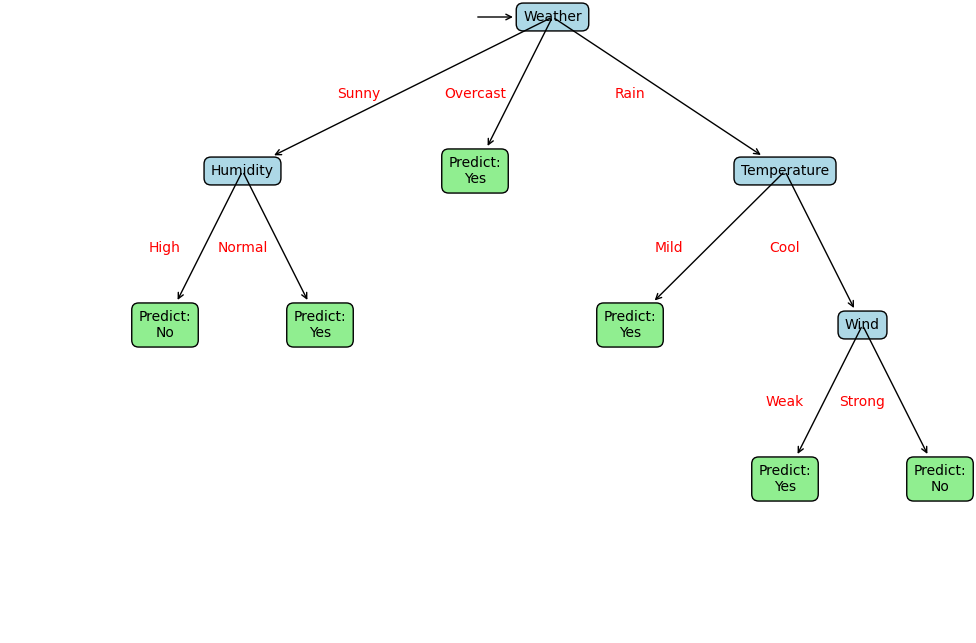

In [ ]:
import pandas as pd
import math
import matplotlib.pyplot as plt

def entropy(data, target_col):
    counts = data[target_col].value_counts()
    total = len(data)
    ent = 0
    for count in counts:
        p = count / total
        ent -= p * math.log2(p)
    return ent

def info_gain(data, feature, target_col):
    total_entropy = entropy(data, target_col)
    values = data[feature].unique()
    weighted_entropy = 0
    for val in values:
        subset = data[data[feature] == val]
        weighted_entropy += (len(subset) / len(data)) * entropy(subset, target_col)
    return total_entropy - weighted_entropy

def split_info(data, feature):
    total = len(data)
    values = data[feature].value_counts()
    split = 0
    for count in values:
        p = count / total
        split -= p * math.log2(p)
    return split

def gain_ratio(data, feature, target_col):
    ig = info_gain(data, feature, target_col)
    si = split_info(data, feature)
    if si == 0:
        return 0
    return ig / si

def majority_class(data, target_col):
    return data[target_col].mode()[0]

def c45(data, features, target_col, depth=0, max_depth=None):
    labels = data[target_col].unique()
    if len(labels) == 1:
        return {'label': labels[0]}
    if len(features) == 0 or (max_depth is not None and depth >= max_depth):
        return {'label': majority_class(data, target_col)}
    gains = [(feature, gain_ratio(data, feature, target_col)) for feature in features]
    best_feature, best_gain = max(gains, key=lambda x: x[1])
    if best_gain == 0:
        return {'label': majority_class(data, target_col)}
    tree = {'feature': best_feature, 'nodes': {}}
    remaining_features = [f for f in features if f != best_feature]
    for val in data[best_feature].unique():
        subset = data[data[best_feature] == val]
        if subset.empty:
            tree['nodes'][val] = {'label': majority_class(data, target_col)}
        else:
            subtree = c45(subset, remaining_features, target_col, depth + 1, max_depth)
            tree['nodes'][val] = subtree
    return tree

def plot_node(text, center_point, parent_point, ax, node_type='decision'):
    box_style = dict(boxstyle="round,pad=0.5", fc="lightblue" if node_type=='decision' else "lightgreen")
    ax.annotate(text,
                xy=parent_point, xycoords='axes fraction',
                xytext=center_point, textcoords='axes fraction',
                va="center", ha="center",
                bbox=box_style,
                arrowprops=dict(arrowstyle="<-"))

def get_num_leaves(tree):
    if 'label' in tree:
        return 1
    leaves = 0
    for subtree in tree['nodes'].values():
        leaves += get_num_leaves(subtree)
    return leaves

def get_tree_depth(tree):
    if 'label' in tree:
        return 1
    depths = []
    for subtree in tree['nodes'].values():
        depths.append(1 + get_tree_depth(subtree))
    return max(depths)

def plot_tree(tree, parent_point, node_text, ax, total_w, total_d, x_off, y_off):
    num_leaves = get_num_leaves(tree)
    center_point = (x_off + (1.0 + num_leaves) / (2.0 * total_w), y_off)
    if 'label' in tree:
        plot_node(f"Predict:\n{tree['label']}", center_point, parent_point, ax, node_type='leaf')
    else:
        plot_node(f"{tree['feature']}", center_point, parent_point, ax, node_type='decision')
    if 'nodes' in tree:
        y_off_new = y_off - 1.0 / total_d
        for val, subtree in tree['nodes'].items():
            num_leaves_sub = get_num_leaves(subtree)
            x_off_new = x_off
            plot_tree(subtree, center_point, str(val), ax, total_w, total_d, x_off_new, y_off_new)
            x_off += num_leaves_sub / total_w
            mid_x = (center_point[0] + x_off_new + num_leaves_sub / (2.0 * total_w)) / 2
            mid_y = (center_point[1] + y_off_new) / 2
            ax.text(mid_x, mid_y, str(val), va='center', ha='center', color='red', fontsize=10)

def draw_tree(tree):
    fig, ax = plt.subplots(figsize=(12,8))
    ax.axis('off')
    total_w = get_num_leaves(tree)
    total_d = get_tree_depth(tree)
    plot_tree(tree, (0.5,1.0), '', ax, total_w, total_d, 0.0, 1.0)
    plt.show()

data = {
    'Weather': ['Sunny', 'Sunny', 'Overcast', 'Rain', 'Rain', 'Rain', 'Overcast', 'Sunny', 'Sunny', 'Rain'],
    'Temperature': ['Hot', 'Hot', 'Hot', 'Mild', 'Cool', 'Cool', 'Cool', 'Mild', 'Cool', 'Mild'],
    'Humidity': ['High', 'High', 'High', 'High', 'Normal', 'Normal', 'Normal', 'High', 'Normal', 'Normal'],
    'Wind': ['Weak', 'Strong', 'Weak', 'Weak', 'Weak', 'Strong', 'Strong', 'Weak', 'Weak', 'Strong'],
    'PlayTennis': ['No', 'No', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'No', 'Yes', 'Yes']
}

df = pd.DataFrame(data)
features = list(df.columns[:-1])
target_col = 'PlayTennis'

tree = c45(df, features, target_col)
draw_tree(tree)


Training Accuracy: 1.0
Testing Accuracy: 1.0


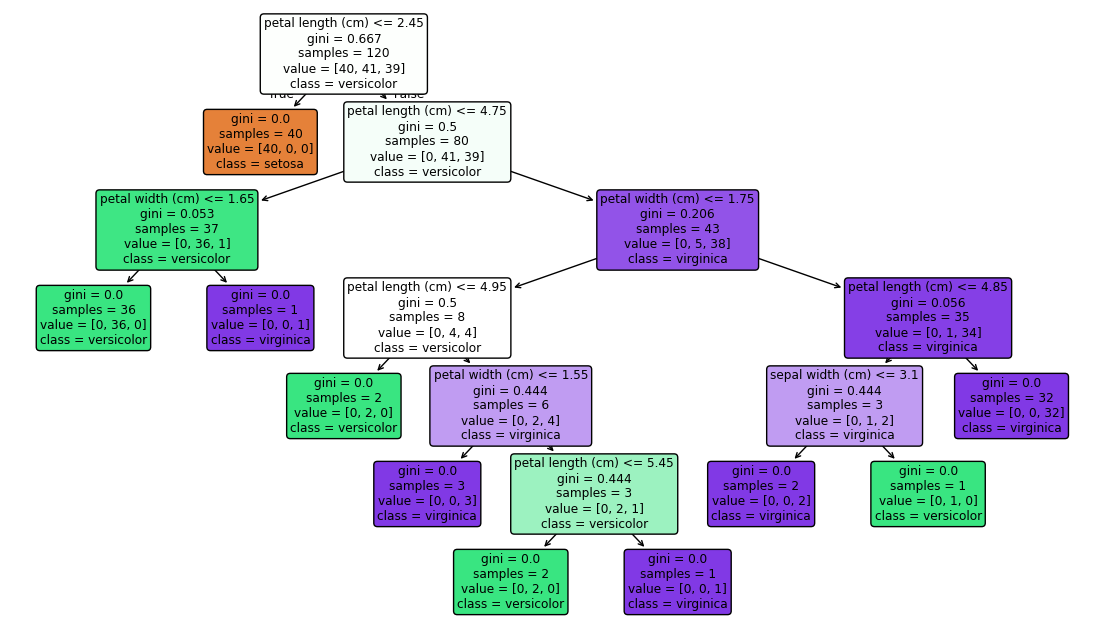

In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
import pandas as pd

iris = load_iris()
X = iris.data
y = iris.target

df = pd.DataFrame(X, columns=iris.feature_names)
df['target'] = y

feature_names = iris.feature_names
class_names = iris.target_names

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = DecisionTreeClassifier(criterion="gini", random_state=42)
clf.fit(X_train, y_train)

print("Training Accuracy:", clf.score(X_train, y_train))
print("Testing Accuracy:", clf.score(X_test, y_test))

plt.figure(figsize=(14,8))
plot_tree(clf, feature_names=feature_names, class_names=class_names, filled=True, rounded=True)
plt.show()
